<div style="background-color: orange; color: white; border-radius: 32px; height:50px">
    <center><h1 style="display:block; padding:7px">Step 0. What is CNN? 📚</h1></center>
</div>

**A convolutional neural network (CNN)** is a type of artificial neural network used in image recognition and processing that is specifically designed to process **pixel data**.

There are 5 Steps for Image Classification by CNN.

#### 1. Image Data Loading(+EDA)
#### 2. Image Data Preprocessing(Label Encoding, Data Augmentation, etc..)
#### 3. Modeling(Building, Fitting,etc..)
#### 4. Prediction of Test Data set

Let's Get Started!

Reference: https://velog.io/@eodud0582/cnn-ox-image-classification

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt

import cv2

<div style="background-color: skyblue; color: #1434A4; border-radius: 32px; height:50px">
    <center><h1 style="display:block; padding:7px">Step 1. Data Loading 🔎</h1></center>
</div>

## About Data
We have train data and test data of images.
* Images are about plant seedlings at various stages of grown.
* Each image has a filename that is its unique id. 
* The dataset comprises 12 plant species. 
* The goal of the competition is to create a classifier capable of determining a plant's species from a photo. 
The list of species is as follows:

Black-grass, Charlock, Cleavers, Common Chickweed, Common wheat, Fat Hen, Loose Silky-bent, Maize, Scentless Mayweed, Shepherds Purse, Small-flowered Cranesbill, Sugar beet

### Train data loading & Labeling

In [ ]:
from glob import glob
import cv2
images_path = '/kaggle/input/plant-seedlings-classification/train/*/*.png'
images = glob(images_path)
train_images = []
train_labels = []

for img in images:
    train_images.append(cv2.resize(cv2.imread(img), (256, 256))) #image is 256x256x3
    train_labels.append(img.split('/')[-2])
train_X = np.asarray(train_images)
train_Y = pd.DataFrame(train_labels)

In [ ]:
train_Y.info()

In [ ]:
train_Y.rename(columns={0:'species'},inplace=True)

### Target Value Count
We know there are 4750 images. (No missing data) 
Check this countplot below. We can also check the number of images per group is not even. 
ex) Suppose the number of data of Class A of Target Column is 100, and Class B is 100. => even   

#### However, if the number of images per group is **not even**, just as our plant-seedling train data, the predicting ability of our model will be poor.

So how are we gonna do?

**1. Reduce some data of the class which has more data**

**2. Duplicate some original data of the class which has less data and use them!**

(+ Or.. just use **stratify** option in sklearn.model_selection.train_test_split)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt                        
%matplotlib inline 
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=train_Y,
    x='species'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [ ]:
plt.imshow(train_X[1])

In [ ]:
train_X.shape #4750 images, width,height: 256, RGB color

In [ ]:
train_Y['species'].value_counts()

<div style="background-color: skyblue; color: #1434A4; border-radius: 32px; height:50px">
    <center><h1 style="display:block; padding:7px">Step 2. Data Preprocessing 🖋</h1></center>
</div>

### 2.1 LabelEncoding Target

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
le = LabelEncoder()
le.fit(train_Y['species'])
encoded_labels = le.transform(train_Y['species'])
train_label = np_utils.to_categorical(encoded_labels) #Data type: Number to Binary

In [ ]:
train_label

In [ ]:
#seed fixing
import random
import os
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

### 2.2 Train Data & Validation Data 
I used stratify option to solve class imbalance problem.

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train_X, train_label,test_size=0.2,random_state=seed, stratify=train_label)

### 2.3 Normalization
**Image normalization** is a typical process in image processing that changes the range of pixel intensity values. Its normal purpose is to convert an input image into a range of pixel values that are more familiar or normal to the senses, hence the term normalization.

In this work, we will perform a function that produces a normalization of an input image
(grayscale or RGB). Then, we understand a representation of the range of values of the scale of the image represented between 0 and 255, in this way we get, for example, that very dark
images become clearer. The linear normalization of a digital image is performed according to
the formula

                   Output_channel = 255 * (Input_channel - min) / (max-min)

If we are using a grayscale image, we only need to normalize using one channel. However, if we are normalizing a RGB (3 channels) we need to normalize for each channel using the same
criteria. Also, in this problem, I did not get maximum or minimum values of image(0~255), just simply divide them by 255. 
[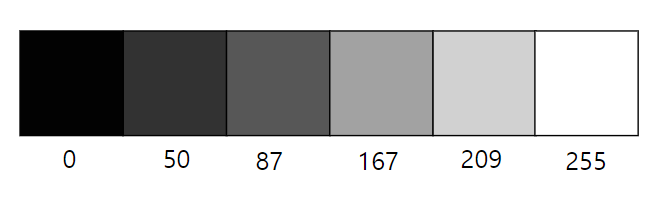](http://)

In [ ]:
# Normalization of the Image Data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255 

In [ ]:
plt.imshow(X_train[0])

### 2.4 ImageDataGenerator
#### * What is Data Augmentation and Why it is needed?
Data Augmentation is a technique used to expand or enlarge your dataset by using the existing data of the dataset. We apply different techniques to expand our dataset so that it will help to train our model better with a large dataset. If you are having a small dataset and if you use that dataset to train your model and overfit the data. So to increase the ability and performance of your model, or to generalize our model we need a proper dataset so that we can train our model. Data Augmentation helps you to achieve this. Image Augmentation is one of the technique we can apply on an image dataset to expand our dataset so that we can prevent overfitting and our model generalizes well.

#### * Image Augmentation Techniques and Implementation
Rotation, Width Shifting, Height Shifting, Brightness, Shear Intensity, Zoom, Channel Shift, Horizontal Flip, Vertical Flip

Let's use **ImageDataGenerator** which is used to generate the batches of tensor image data with real-time data augmentation. 

* Reference: https://medium.com/mlait/image-data-augmentation-image-processing-in-tensorflow-part-2-b77237256df0 , 
https://laheepapa.tistory.com/70

[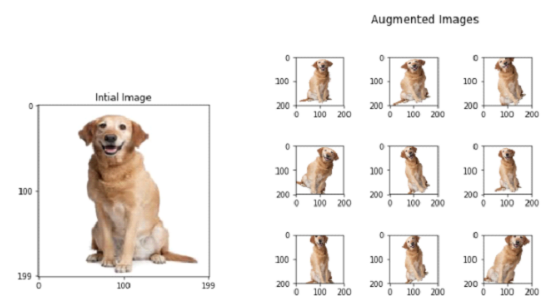](http://)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    )  
datagen.fit(train_X)

<div style="background-color: skyblue; color: #1434A4; border-radius: 32px; height:50px">
    <center><h1 style="display:block; padding:7px">Step 3. Modeling by CNN 💡</h1></center>
</div>

## Before we start modeling....

We should understand convolution, padding, pooling, etc. 
The CNN tutorial link below will be really helpful for CNN beginners. 

https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial/notebook

[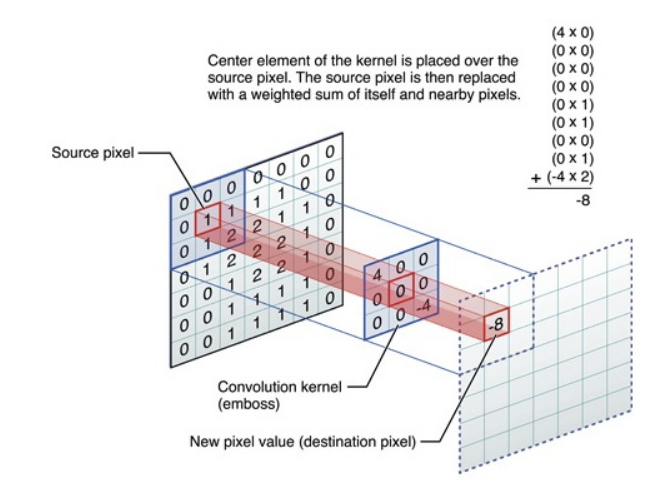](http://)

### Why ReLU?
* ReLU increases non-linearity. (ReLU is a non-linear function, there is no way you could get any shapes on the graph having only linear terms, any linear function can be simplified to a form y = ab + x, which is a straight line.)

### model.add()
Check essential info about some keras methods.

    model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(256, 256, 3), activation='relu'))  

1. filters=64 => The number of kernels
2. kernel_size => literally size of a kernel (row=5, col=5)
3. input_shape => width, height, color or grayscale
4. activation => activation method such as 'relu', 'softmax', etc...

### How to Improve Fitting
* Weight Initialization
* Batch Normalization - Normaliztion per batch to solve gradient vanishing & exploding problem
* Dropout

### 3.1 Build Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(256, 256, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(12, activation='softmax'))

model.summary()

[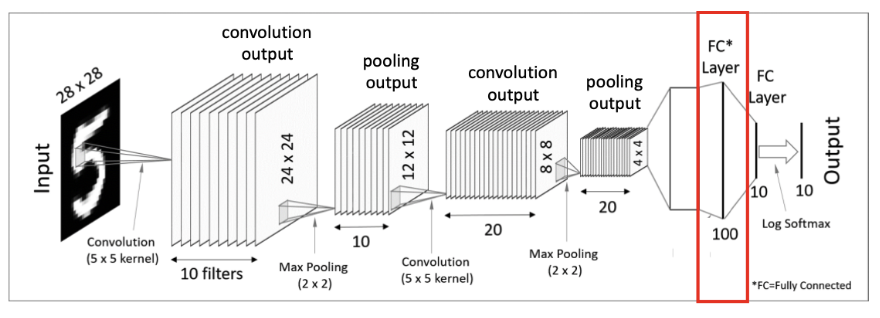](http://)

In [ ]:
#Specify Lass and Optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### ModelCheckpoint

The ModelCheckpoint callback class allows you to define where to checkpoint the model weights, how the file should named and under what circumstances to make a checkpoint of the model.

The API allows you to specify which metric to monitor, such as loss or accuracy on the training or validation dataset. You can specify whether to look for an improvement in maximizing or minimizing the score. Finally, the filename that you use to store the weights can include variables like the epoch number or metric.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint


#### EarlyStopping
Stop training when a monitored metric has stopped improving.

Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be 'loss', and mode would be 'min'. A model.fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta and patience if applicable. Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.

https://keras.io/api/callbacks/early_stopping/

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
model_checkpoint = ModelCheckpoint('/kaggle/working/plantspecies_CNN_model.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
#Stop fitting if there's no enhancement of accuracy for 10 times.

### 3.2 Fit Model

In [ ]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=8), 
                    epochs=30, validation_data=(X_test, y_test),   
                    callbacks = [early_stopping, model_checkpoint])

### 3.3 Predict & Evaluate Model

In [ ]:
#Final score and accuracy of the model
score, acc = model.evaluate(X_test,y_test)
#score1, acc1 = model.evaluate(X_train,y_train)
print('Validation score:', score,'   Validation accuracy:', acc)
#print('Train score:', score1,'   Train accuracy:',acc1)

* Visualization of Prediction

https://www.tensorflow.org/tutorials/keras/classification?hl=ko

In [ ]:
predictions = model.predict(X_test)

In [ ]:
class_names = le.classes_

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = np.argmax(true_label[i])
  plt.grid(False)
  plt.xticks(range(12))
  plt.yticks([])
  thisplot = plt.bar(range(12), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
predictions[0]
#This value means confidence that corresponds to 12 species, and we can find the highest confidence by np.argmax

In [ ]:
np.argmax(predictions[0])

In [ ]:
#Correct Prediction
i = 17
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

In [ ]:
#Incorrect Prediction
i = 11
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

<div style="background-color: skyblue; color: #1434A4; border-radius: 32px; height:50px">
    <center><h1 style="display:block; padding:7px">Step 4. Predict Test Data ✨</h1></center>
</div>

In [ ]:
test_images_path = '/kaggle/input/plant-seedlings-classification/test/*.png'
test_images = glob(test_images_path)
test_images_arr = []
test_files = []

for img in test_images:
    test_images_arr.append(cv2.resize(cv2.imread(img), (256, 256)))
    test_files.append(img.split('/')[-1])

test_X = np.asarray(test_images_arr)

In [ ]:
# Normalization of the Image Data
test_X = test_X.astype('float32') / 255

In [ ]:
pred = model.predict(test_X)
pred_class = np.argmax(pred, axis=1)
pred_str = le.classes_[pred_class]
final_pred = {'file':test_files, 'species':pred_str}
final_pred = pd.DataFrame(final_pred)
final_pred.to_csv("Plant-Seedlings-CNN-kiy.csv", index=False)
#final_predictions

### Reference Code
Thanks for sharing, notebooks of nikkonst and akashwadhwaai helped me(the CNN novice) a lot. 
I really appreciate it. Thank you!

https://www.kaggle.com/code/nikkonst/plant-seedlings-with-cnn-and-image-processing/notebook

https://www.kaggle.com/code/akashwadhwaai/plant-seedlings-classification/notebook
